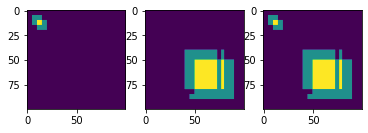

1===================
                                               Pixel     Other
tp                                        [9825, 25]       NaN
fn                                          [75, 75]       NaN
fp                                          [75, 75]       NaN
tn                                        [25, 9825]       NaN
dice          [0.9924242424241922, 0.24999999999875]       NaN
accuracy    [0.9849999999999015, 0.9849999999999015]       NaN
iou        [0.9849624060149388, 0.14285714285632653]       NaN
precision      [0.9924242424241422, 0.2499999999975]       NaN
recall         [0.9924242424241422, 0.2499999999975]       NaN
fscore         [0.9924242424241422, 0.2499999999975]       NaN
fpr                     [0.75, 0.007575757575757576]       NaN
hd                                               NaN  7.071068
hd95                                             NaN  6.403124
asd                                              NaN  3.847433
assd                              

In [146]:
import numpy as np
all={i:{'gt':np.zeros((100,100)),'pred':np.zeros((100,100))} for i in  range(1,4)}


all[1]['gt'][10:20,10:20]=1
all[1]['pred'][5:15,5:15]=1

all[2]['gt'][50:90,50:90]=1
all[2]['gt'][85:90,45:90]=1
all[2]['pred'][40:80,40:80]=1
all[2]['pred'][40:80,73:77]=0

all[3]['gt']=all[1]['gt']+all[2]['gt']
all[3]['pred']=all[1]['pred']+all[2]['pred']


import matplotlib.pyplot as plt

for i in range(1,4):
    plt.subplot(1,len(all),i)
    plt.imshow(all[i]['gt']+all[i]['pred'])
plt.show()

import metric 
metrics={'Pixel':metric.PixelBasedCM(2),
        'Other':metric.Other(2)}

def calc_metrics(metrics,gt,pred,helper):
    metric_res={}
    for m in metrics:
        metric_res[m]=metrics[m].evaluate(gt,pred,helper)
    return metric_res

helper=None
import pandas as pd
for i in range(1,4):
    print(f'{i}===================')
    res = calc_metrics(metrics, all[i]['gt'],all[i]['pred'],helper)
    print(pd.DataFrame(res))
        

# print(res)

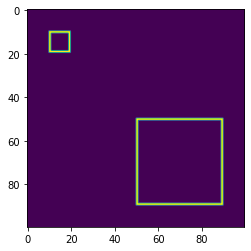

In [45]:
from scipy.ndimage import generate_binary_structure, binary_erosion,distance_transform_edt
reference = np.atleast_1d(all[3]['gt'].astype(bool))
footprint = generate_binary_structure(reference.ndim, connectivity=1)
from scipy.ndimage import label, find_objects
x=~binary_erosion(reference, structure=footprint, iterations=1)& (reference)
plt.imshow(x)
plt.show()

[1]
{'detected': True, 'uniform_gt': 1.0, 'uniform_pred': 1.0, 'maxd': 4.0, 'hd': 7.0710678118654755, 'hd95': 5.665559131760026, 'hd_avg': 2.9184800132910613, 'hdn': 1.7677669529663689, 'hdn_95': 1.4163897829400065, 'hdn_avg': 0.7296200033227653}
[7.07106781 6.40312424 5.83095189 5.38516481 5.09901951 5.
 5.         5.         5.         5.         6.40312424 4.
 5.83095189 3.         5.38516481 2.         5.09901951 1.
 5.         0.         5.         1.         5.         2.
 5.         3.         5.         4.         3.         2.
 1.         0.         1.         2.         3.         4.        ]
[2 3]
{'detected': True, 'uniform_gt': 0.5, 'uniform_pred': 1.0, 'maxd': 19.0, 'hd': 19.0, 'hd95': 15.0, 'hd_avg': 6.86784296094997, 'hdn': 1.0, 'hdn_95': 0.7894736842105263, 'hdn_avg': 0.36146541899736684}
[14.14213562 13.45362405 12.80624847 12.20655562 11.66190379 11.18033989
 10.77032961 10.44030651 10.19803903 10.04987562 10.         10.
 10.         10.         10.         10.     

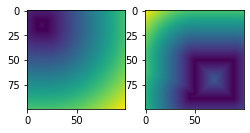

In [186]:
import cc3d
reference=all[3]['gt']
test=all[3]['pred']
gt_labels, gN = cc3d.connected_components(reference, return_N=True) 
pred_labels, pN = cc3d.connected_components(test, return_N=True) 

plt.subplot(1,2,1)
plt.imshow(gt_labels)
plt.subplot(1,2,2)
plt.imshow(pred_labels)

footprint = generate_binary_structure(reference.ndim, connectivity=1)
    
for i in range(1,gN+1):
    component_gt=gt_labels==i
    
    
    rel_pred=pred_labels[component_gt]
    pred_comp=np.unique(rel_pred)
    pred_comp=pred_comp[pred_comp>0]
    
    component_pred=np.zeros(component_gt.shape,bool)
    for l in pred_comp:
        component_pred|=pred_labels==l
    rel_gts=np.unique(component_gt[component_pred])
    rel_gts=rel_gts[rel_gts>0]
    
    print(pred_comp)
    border_gt=~binary_erosion(component_gt, structure=footprint, iterations=1)& (component_gt)
    border_pred=~binary_erosion(component_pred, structure=footprint, iterations=1)& (component_pred)
    dst=distance_transform_edt(~border_gt)
    
    plt.subplot(1,N+1,i)
    plt.imshow(dst)
#     print(dst[component_gt])
    max_dst_gt=dst[component_gt].max()
    hd=dst[component_pred].max()
    hd_avg=dst[component_pred].mean()
    hd95=np.quantile(dst[component_pred],0.95)
    res={
        'detected':sum(pred_comp)>0,
        'uniform_gt':1./len(pred_comp),
        'uniform_pred':1./len(rel_gts),
        'maxd':max_dst_gt,
    'hd':hd,
    'hd95':hd95,
    'hd_avg':hd_avg,
    'hdn':hd/max_dst_gt,
    'hdn_95':hd95/max_dst_gt,
    'hdn_avg':hd_avg/max_dst_gt}
    print(res)
#     border_dst_shape=np.zeros(component_gt.shape,bool)
#     border_dst_shape[border_pred]=dst[border_pred]
#     plt.imshow(border_dst_shape)

    print(dst[border_pred])
    

print(dst[0,0])

In [188]:

base=np.zeros((x.shape[0],x.shape[1],3), np.uint8)
base[x>0]=(255,255,255)
im2 = cv2.cvtColor(base,cv2.COLOR_BGR2GRAY) #gray scale image

im3, contours = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
# print(im3)
# cv2.drawContours(base, contours, -1, (0,255,0), 3)
from opencv_jupyter_ui import cv2_imshow
cv2_imshow('a',im3[0])


ValueError: buffer is not large enough

TypeError: Invalid shape (396, 1, 2) for image data

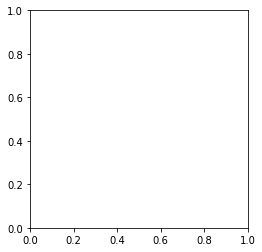

In [116]:
# Threshold via Otsu:
_, binaryImage = cv2.threshold(im2, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(im3[0])

3

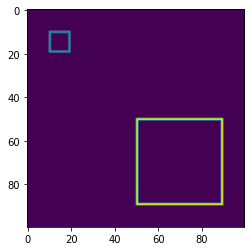

In [128]:
output = cv2.connectedComponents(
	im2, 1, cv2.CV_32S)
(numLabels, labels) = output
plt.imshow(labels)
numLabels

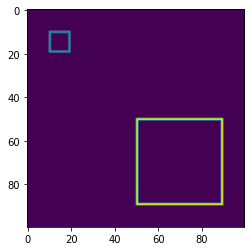

In [133]:
import cc3d

labels, N = cc3d.connected_components(x, return_N=True) # free
plt.imshow(labels)

In [193]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import skimage 

def plot_3d(image, threshold=-300): 
    p = image#.transpose(2,1,0)
    verts, faces, normals, values = skimage.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

plot_3d(gt)

AttributeError: No skimage attribute marching_cubes_lewiner

In [195]:
!echo "ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQC+3T4wtR/tedooRrbiozZ2GUKtTf0fXaE+iA6JKXh04cX3QIpe7BJCoItUVFYJ8TSjmPO0GoaxbzUwQlZO0CCQVKf7/dFt0bP0ceCz/Q8GEETq+GFv6wiLxBBkcobkgvbJ6V/pLfCNUFZ/bfowmFNCdOvSZuoLj8Mgu4wD9DiCAjj068oe9AUuDQnS94vZBg3Ljo11dzT8PvlxVR057HbZjVEWfGck3AxZrsZNBXfTO+N4sp3x/N+AHG767JCAh2hzYAPiVd72uCk2OtlKmaHW9fsPwLT+KZR4kt7vDI2l7CSugWtGDcUDD68q3VMgQbkz9/1+XgfmBoT6n3ESymzX MK">>~/.ssh/authorized_keys